In [1]:
import numpy as np
import pandas as pd 
import scipy
import glob
import os
import random 
import math

import keras
import keras.applications
from keras.models import Sequential, Model
from keras.layers import *
from keras.regularizers import *
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
import tensorflow as tf
print("tensorflow - {}".format(tf.__version__))
print("keras - {}".format(keras.__version__))

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.feature_extraction import image
import sklearn.preprocessing 
import sklearn.model_selection
import seaborn as sns 

%matplotlib inline


Using TensorFlow backend.


tensorflow - 0.11.0rc2
keras - 1.2.0


In [2]:
%run '../general/datasets.py'

In [3]:
%run '../general/dl.py'

In [4]:
%run '../general/plotting.py'

In [268]:
keras.applications.VGG16().summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 224, 224, 64)  1792        input_3[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 224, 224, 64)  36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 112, 112, 64)  0           block1_conv2[0][0]               
___________________________________________________________________________________________

## Load VGG model

In [124]:
def create_model(opt='adam', train_all=False):
    base_model = keras.applications.vgg16.VGG16(include_top=False, input_shape=(100,100,3))
    
    x = base_model.output
    x = BatchNormalization(name='bn')(x)
    x = Convolution2D(16,1,1, name='detectors_spatial')(x)
    x = GlobalMaxPooling2D(name='detectors')(x)
        
    x = Dense(2, name='output', activation='linear')(x)
    x = Activation('softmax')(x)
    
    # Compile model
    model = Model(input=base_model.input, output=x)
    
    if not train_all:
        for l in base_model.layers:
            l.trainable = False
    
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model
    

In [125]:
model = create_model()

In [126]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_6 (InputLayer)             (None, 100, 100, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 100, 100, 64)  1792        input_6[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 100, 100, 64)  36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 50, 50, 64)    0           block1_conv2[0][0]               
___________________________________________________________________________________________

In [291]:
ts = ((data.train.X - X_train_means)/X_train_std)[data.train.y[:,0]==1]

In [236]:
detector_num=2
reg = 0.0001

inp = model.input
out = model.get_layer('detectors').output[:,detector_num]
# sqrt_sum_square_inp = K.sqrt(K.sum(K.square(inp)))
score = out - reg * K.sum(K.square(inp))

grads = K.gradients([score], [inp])[0]
grads /= K.sqrt(K.sum(K.square(grads)) + 1e-5)

itr = K.function([inp, K.learning_phase()], [out, score, grads])

curr_inp = np.random.random((1,100,100,3))*0.000001

curr_inp_samples = []

In [253]:
#lrs = [1.5]*20 + [1]*60 + [0.5]*80 
lrs = [0.3] * 1000

In [254]:
for ctr, lr in enumerate(lrs):
    curr_act, curr_score, curr_grads = itr([curr_inp, False])
    print("[{}] curr_score = {}  , curr_act = {}".format(ctr, curr_score[:5], curr_act[:5]))

    curr_inp += lr * curr_grads
#    lr *= 0.98
    
    if ctr % 10 == 0:
        curr_inp_samples.append(curr_inp.copy())
        

[0] curr_score = [ 18.33126259]  , curr_act = [ 18.3460865]
[1] curr_score = [ 18.43777657]  , curr_act = [ 18.45283318]
[2] curr_score = [ 18.57998276]  , curr_act = [ 18.59525871]
[3] curr_score = [ 18.65488625]  , curr_act = [ 18.67038345]
[4] curr_score = [ 18.82543755]  , curr_act = [ 18.84114456]
[5] curr_score = [ 18.92099762]  , curr_act = [ 18.93695831]
[6] curr_score = [ 19.07229042]  , curr_act = [ 19.08847046]
[7] curr_score = [ 19.1739254]  , curr_act = [ 19.19035149]
[8] curr_score = [ 19.3202343]  , curr_act = [ 19.33688164]
[9] curr_score = [ 19.42644501]  , curr_act = [ 19.44335175]
[10] curr_score = [ 19.5573864]  , curr_act = [ 19.57453346]
[11] curr_score = [ 19.6563549]  , curr_act = [ 19.67373276]
[12] curr_score = [ 19.79864883]  , curr_act = [ 19.81627274]
[13] curr_score = [ 19.88265991]  , curr_act = [ 19.90052986]
[14] curr_score = [ 20.0024662]  , curr_act = [ 20.02056122]
[15] curr_score = [ 20.10514259]  , curr_act = [ 20.12347603]
[16] curr_score = [ 20.2

KeyboardInterrupt: 

In [255]:
K.function([model.input, K.learning_phase()], [model.get_layer('detectors').output])([curr_inp, False])
#K.function([model.input, K.learning_phase()], [model.get_layer('detectors').output])([data.train.X[0:1], False])

[array([[ -0.43003947,   2.69109416,  71.87274933,   0.16790786,
           9.28312016,   4.76583862,   3.3308394 ,  18.40731621,
           7.81467915,  48.56570816,   0.43944809,  29.89235687,
           0.84628695,  -0.57637477,   1.09253109,   2.03339267]], dtype=float32)]

In [256]:
model.get_layer('output').get_weights()

[array([[ 0.27109486, -0.11291291],
        [-0.22888117,  0.03300301],
        [-0.20184016, -0.50457054],
        [ 0.53118324, -0.23185858],
        [-0.1813878 ,  0.48769176],
        [ 0.39769194, -0.30150345],
        [-0.55437094,  0.22788614],
        [-0.44877508,  0.3522298 ],
        [ 0.08102644, -0.33738112],
        [ 0.32758439, -0.38668376],
        [-0.28999281,  0.54131109],
        [-0.00380414,  0.18483244],
        [ 0.54506117, -0.31558123],
        [ 0.16870326, -0.46456549],
        [-0.34308892, -0.17354558],
        [-0.07077549,  0.2318355 ]], dtype=float32),
 array([-0.01720787,  0.01720786], dtype=float32)]

In [257]:
model.predict(curr_inp)

array([[  1.00000000e+00,   9.66368878e-15]], dtype=float32)

/Users/zach/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


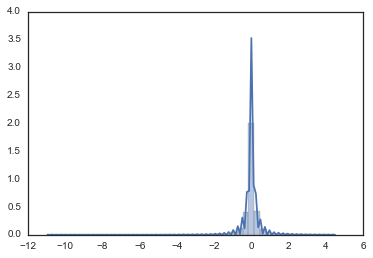

In [258]:
sns.distplot(curr_inp.flatten())

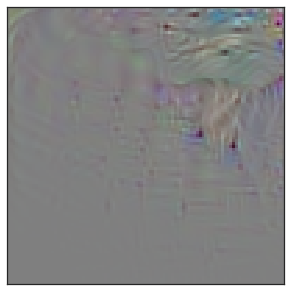

In [261]:
#display_analyzed_layer(al, display_limit=None)
sns.set_style('white')
#inp = curr_inp
#inp = np.array(curr_inp_samples).squeeze()
inp = curr_inp_samples[14]
inp = inp * X_train_std + data.train.X.mean()
#inp = inp.clip(0,255)/255
#inp = (inp - inp.min()) / (inp.max() - inp.min())

gridplot(inp, num_cols=3)


In [447]:
def occluding_analysis(img, patch=(5,5), stride=3, required_class=0, score_func=None):
    original_score = model.predict(img[None,:])[0,required_class]
    
    ys = range(0,img.shape[0],stride)
    xs = range(0,img.shape[1],stride)
    occ_imgs = np.repeat(img[None,:], len(xs)*len(ys), axis=0)
    for ind_i, i in enumerate(ys):
        for ind_j, j in enumerate(xs):
            occ_imgs[ind_i*len(xs)+ind_j, i:i+patch[0], j:j+patch[1], :] = 0
        
    if not score_func:
        occ_scores = model.predict(occ_imgs)[:,required_class]
    else:
        occ_scores = score_func(occ_imgs)
    occ_scores -= original_score
    
    
    res = np.empty((len(xs)*len(ys),) + img.shape[:2])
    res[:] = np.NAN
    for ind_i, i in enumerate(ys):
        for ind_j, j in enumerate(xs):
            ind = ind_i*len(xs)+ind_j
            res[ind, i:i+patch[0], j:j+patch[1]] = occ_scores[ind]
    
    res = np.nanmean(res, axis=0)
    
    return res

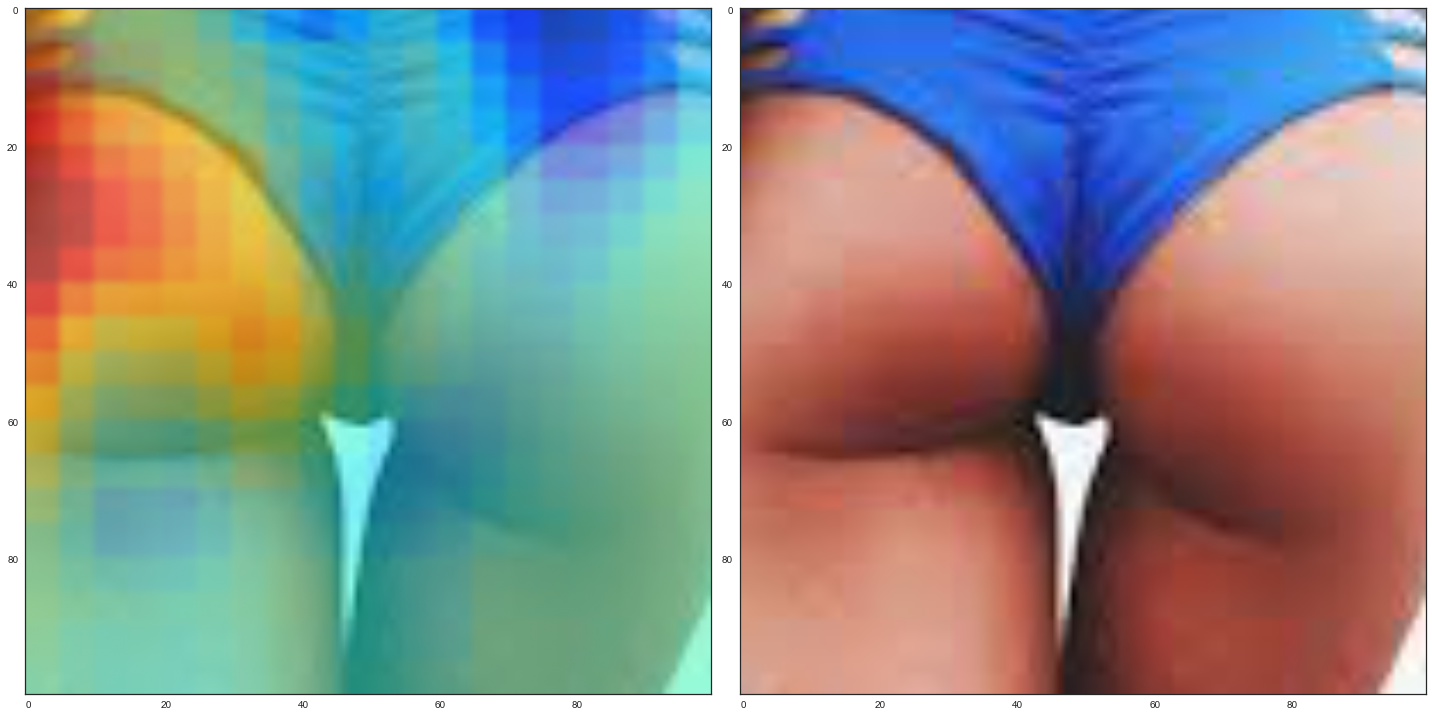

In [462]:
inp = data.train.X[56]

det_act_func = K.function([model.input, K.learning_phase()], [model.get_layer('detectors').output])

detector = lambda det_num: lambda i: det_act_func([i,False])[0][:,det_num]

res = occluding_analysis(inp, patch=(20,20), stride=5, score_func=detector(12), required_class=0)

fig = plt.figure(figsize=(20,10))

gs = gridspec.GridSpec(1,2)

ax = plt.Subplot(fig, gs[0, 0])
ax.imshow(inp.squeeze())
im = ax.imshow(res, interpolation='bicubic', cmap=plt.cm.jet_r, alpha=0.5)
fig.add_subplot(ax)

ax = plt.Subplot(fig, gs[0, 1])
ax.imshow(inp.squeeze())
fig.add_subplot(ax)

fig.tight_layout()


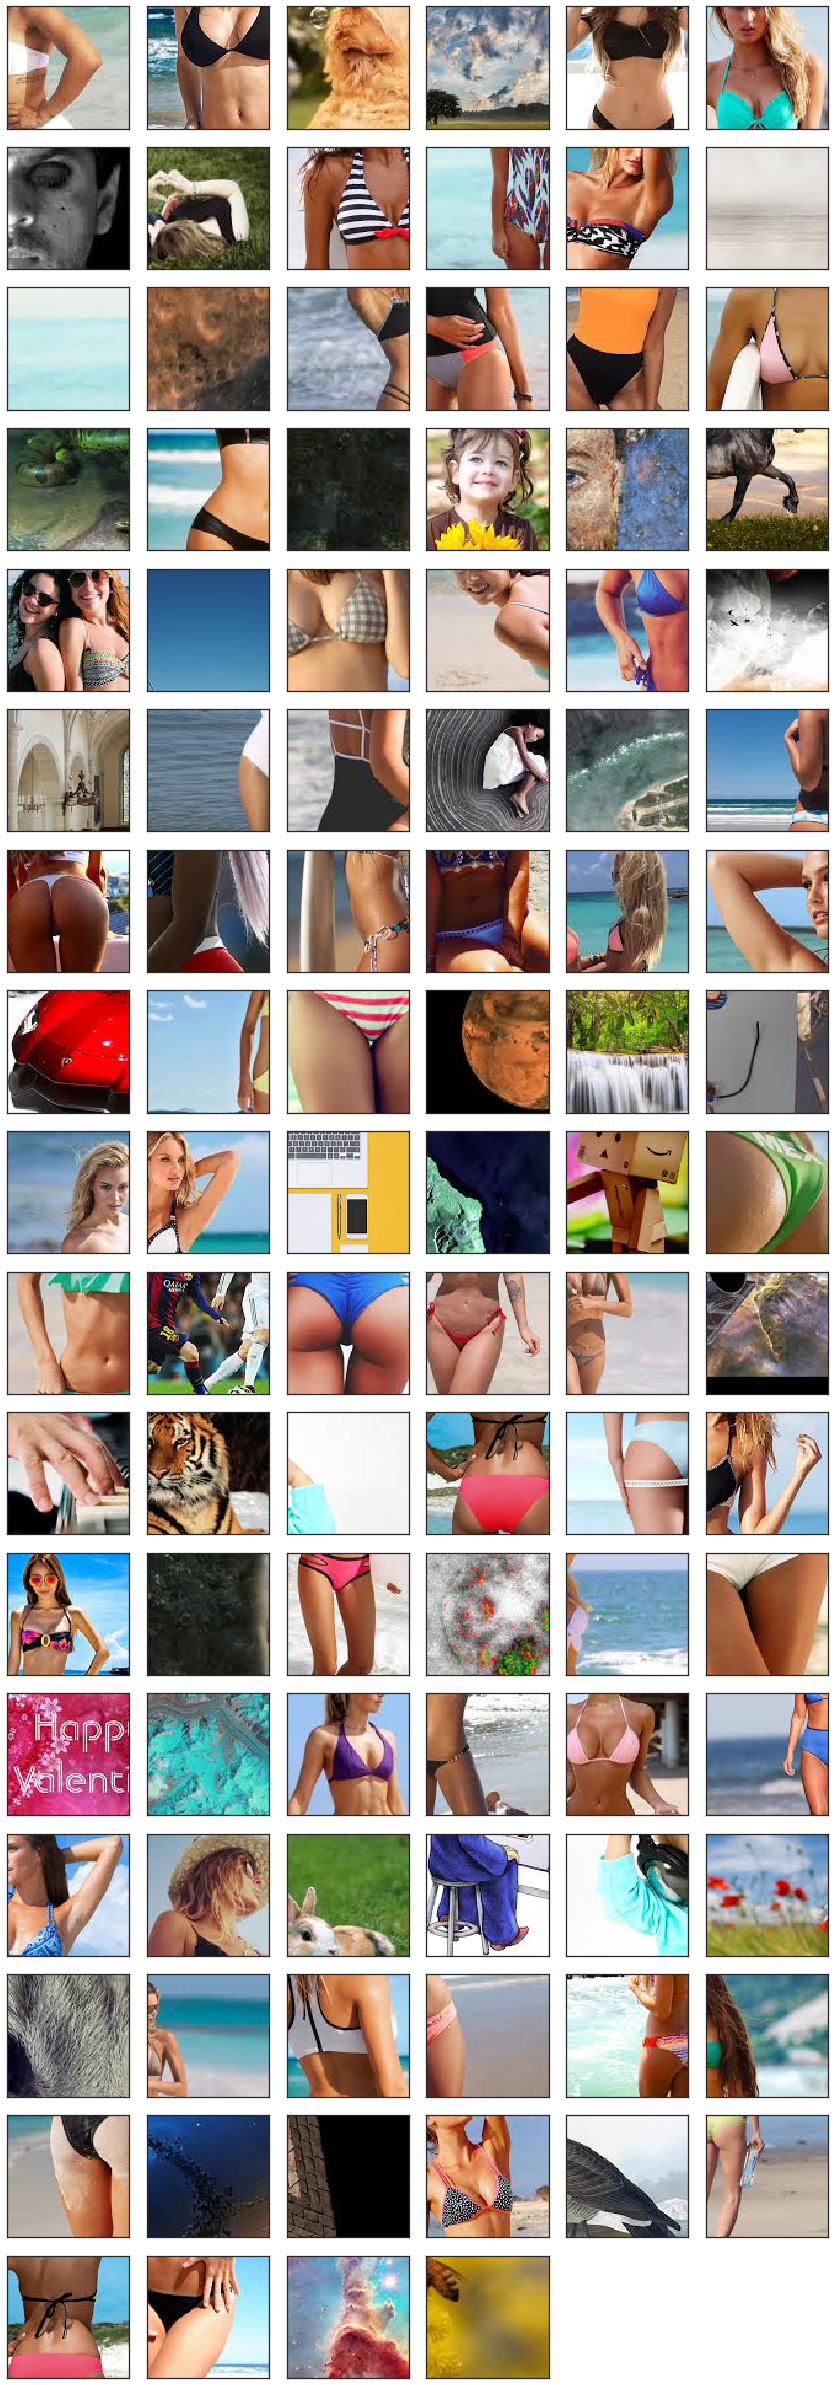

In [461]:
#res, occ_scores = occluding_analysis(inp, patch=(20,20), stride=20, score_func=detector(10), required_class=0)
gridplot(data.train.X[:100], titles=list(range(100))

# Load training set
## Extract patches from images

In [7]:
import pickle
import bz2
import gzip
import time

with bz2.BZ2File("data/dataset.pickle.bz2", 'r') as f:
    data = pickle.load(f)


In [45]:
DATA_PATH = "data"
N_PATCHES_PER_IMAGE = 4
PATCH_SIZE = (100, 100)


def extract_patches(directory):
    Xs = []
    ys = []
    
    for label_dir in glob.glob("{}/*".format(directory)):
        label = os.path.basename(label_dir)
        
        for filename in glob.glob("{}/*".format(label_dir)):
            img = scipy.misc.imread(filename, mode='RGB')
            if (img.shape[0]<PATCH_SIZE[0] or img.shape[1]<PATCH_SIZE[1]): continue
            
            t = image.extract_patches_2d(img, PATCH_SIZE, max_patches=N_PATCHES_PER_IMAGE)
            Xs.append(t)
            ys.append([label]*t.shape[0])

    return np.concatenate(Xs), np.concatenate(ys)
            
            
Xs, ys = extract_patches(DATA_PATH)
Xs = Xs.astype(float) / 255.0


# Encode labels as OneHot vectors

In [18]:
l_enc = sklearn.preprocessing.LabelEncoder()
oh_enc = sklearn.preprocessing.OneHotEncoder()

def encode_ys(ys):
    ysl = l_enc.fit_transform(ys).reshape(-1,1)
    return oh_enc.fit_transform(ysl).toarray()

def decode_ys(yse):
    l = np.argmax(yse, axis=1)
    return l_enc.inverse_transform(l)
     
yse = encode_ys(ys)

NameError: name 'ys' is not defined

## Build datasets

In [47]:
data = Datasets(Xs, yse, test_split=0.4, train_dev_split=0.1, dev_split=0.5, small=500)

In [48]:
data.show()

train
  - X: (2647, 100, 100, 3)
  - y: (2647, 2)
train_dev
  - X: (295, 100, 100, 3)
  - y: (295, 2)
dev
  - X: (981, 100, 100, 3)
  - y: (981, 2)
test
  - X: (981, 100, 100, 3)
  - y: (981, 2)
small
train
  - X: (500, 100, 100, 3)
  - y: (500, 2)
test
  - X: (500, 100, 100, 3)
  - y: (500, 2)


In [ ]:
import pickle
import bz2
import gzip
import time

with bz2.BZ2File("data/dataset.pickle.bz2", 'w') as f:
    pickle.dump(data, f)


# calc mean/std of images

In [35]:
X_train_means = data.train.X.mean(axis=0)
X_train_std = data.train.X.std(axis=(0,1,2))

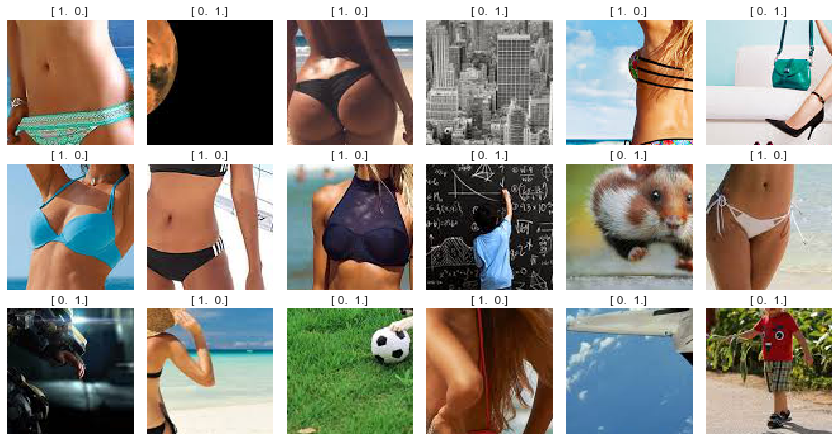

In [9]:
sample_idx = np.random.choice(np.arange(data.train.X.shape[0]), 18, replace=False)
gridplot(data.train.X[sample_idx], titles=data.train.y[sample_idx])

# Build ConvNet

In [95]:
H,W,DIMS = 100, 100, 3

def build_detector_model(opt='adam', num_filters=(64,64,64,32,32), batchnorm=True):
    model = Sequential()

    # Adding CONV0 layers
    model.add(ZeroPadding2D(padding=(2, 2), input_shape=(H,W,DIMS)))
    model.add(Convolution2D(num_filters[0],5,5, name='conv0_0', activation='relu'))
    model.add(ZeroPadding2D(padding=(2, 2)))
    model.add(Convolution2D(num_filters[1],5,5, name='conv0_1', activation='relu'))
    model.add(ZeroPadding2D(padding=(2, 2)))
    model.add(Convolution2D(num_filters[2],5,5, name='conv0_2', activation='relu'))
    model.add(ZeroPadding2D(padding=(2, 2)))
    model.add(Convolution2D(num_filters[3],5,5, name='conv0_3', activation='relu'))
    model.add(ZeroPadding2D(padding=(2, 2)))
    model.add(Convolution2D(num_filters[4],5,5, name='conv0_4', activation='linear'))
    if batchnorm:
        model.add(BatchNormalization(name='bn_conv0', momentum=0.9, mode=0, axis=-1))
    model.add(Activation('relu'))
        

    # Adding MAXPOOLING 
    ll = model.layers[-1].output_shape[1:3]
    model.add(MaxPooling2D(ll, name='maxpooling_conv0'))

    # FC to outputs
    model.add(Flatten())
    model.add(Dense(2, name='output', activation='linear'))
    model.add(Activation('softmax'))
    
    # Compile model
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model          

In [93]:
def build_model(num_filters=(16,32), fc_size=(32,), reg=True, reg_lambda=0.01):
    model = Sequential()
    
    def additional_args():
        return { 'input_shape': Xs_conv.shape[1:] } if len(model.layers) == 0 else {}
    
    reg_params = dict(W_regularizer=l2(reg_lambda), b_regularizer=l2(reg_lambda))
    
    
    for n in num_filters:
        model.add(Convolution2D(n, 3,3, activation='relu', **additional_args()))
        model.add(Convolution2D(n, 3,3, activation='relu'))
        model.add(MaxPooling2D(pool_size=(2,2)))
        if reg: 
            model.add(Dropout(0.5))

    #model.add(MaxPooling2D(pool_size=model.layers[-1].output_shape[1:3]))

    
    model.add(Flatten())
    
    for n in fc_size:
        model.add(Dense(n, activation='relu', **reg_params))
    
    model.add(Dense(2, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model
                 

In [96]:
model = build_detector_model(batchnorm=True)
model.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
zeropadding2d_10 (ZeroPadding2D) (None, 104, 104, 3)   0           zeropadding2d_input_1[0][0]      
____________________________________________________________________________________________________
conv0_0 (Convolution2D)          (None, 100, 100, 64)  4864        zeropadding2d_10[0][0]           
____________________________________________________________________________________________________
zeropadding2d_11 (ZeroPadding2D) (None, 104, 104, 64)  0           conv0_0[0][0]                    
____________________________________________________________________________________________________
conv0_1 (Convolution2D)          (None, 100, 100, 64)  102464      zeropadding2d_11[0][0]           
___________________________________________________________________________________________

In [127]:
X = (data.train.X - X_train_means) / X_train_std

hist = model.fit(X, data.train.y, nb_epoch=10, verbose=2, validation_split=0.2)

Train on 1058 samples, validate on 265 samples
Epoch 1/10
365s - loss: 0.2829 - acc: 0.8866 - val_loss: 0.2322 - val_acc: 0.9396
Epoch 2/10
405s - loss: 0.1154 - acc: 0.9546 - val_loss: 0.1899 - val_acc: 0.9434
Epoch 3/10
324s - loss: 0.0824 - acc: 0.9764 - val_loss: 0.1504 - val_acc: 0.9547
Epoch 4/10
314s - loss: 0.0557 - acc: 0.9868 - val_loss: 0.1299 - val_acc: 0.9623
Epoch 5/10
292s - loss: 0.0478 - acc: 0.9858 - val_loss: 0.1165 - val_acc: 0.9623
Epoch 6/10
294s - loss: 0.0354 - acc: 0.9934 - val_loss: 0.1141 - val_acc: 0.9585
Epoch 7/10
292s - loss: 0.0363 - acc: 0.9934 - val_loss: 0.1074 - val_acc: 0.9585
Epoch 8/10
285s - loss: 0.0278 - acc: 0.9962 - val_loss: 0.1045 - val_acc: 0.9547
Epoch 9/10
287s - loss: 0.0298 - acc: 0.9924 - val_loss: 0.1080 - val_acc: 0.9623
Epoch 10/10
285s - loss: 0.0316 - acc: 0.9924 - val_loss: 0.1102 - val_acc: 0.9736


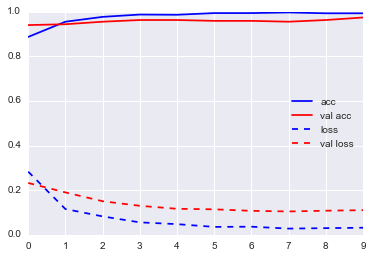

In [128]:
plt.plot(hist.history['acc'], label='acc', c='blue')
plt.plot(hist.history['val_acc'], label='val acc', c='red')
plt.plot(hist.history['loss'], label='loss', c='blue', linestyle='dashed')
plt.plot(hist.history['val_loss'], label='val loss', c='red', linestyle='dashed')
plt.legend(loc='best')

In [129]:
y_test_pred = np.argmax(model.predict((data.test.X - X_train_means)/X_train_std), axis=1)
(y_test_pred == np.argmax(data.test.y, axis=1)).mean()

0.97755102040816322

In [130]:
print(sklearn.metrics.classification_report(np.argmax(data.test.y, axis=1), y_test_pred))
print(sklearn.metrics.confusion_matrix(np.argmax(data.test.y, axis=1), y_test_pred))

             precision    recall  f1-score   support

          0       0.99      0.97      0.98       272
          1       0.97      0.98      0.97       218

avg / total       0.98      0.98      0.98       490

[[265   7]
 [  4 214]]


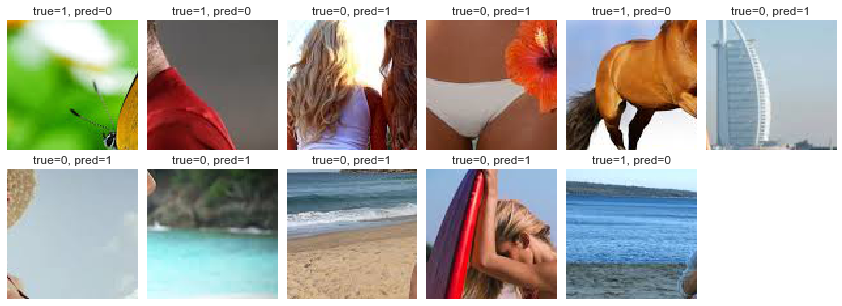

In [131]:
y_true = np.argmax(data.test.y, axis=1)

cond = y_true != y_test_pred
plotdata = data.test.X[cond]
titles = np.array([ "true={}, pred={}".format(t,p) for t,p in zip(y_true,y_test_pred) ])[cond]
gridplot(plotdata, titles=titles)

In [112]:
def get_layer_desc(layer):
    if isinstance(layer, keras.layers.Flatten):
        return ""
    elif isinstance(layer, keras.layers.Dense):
        return ""
    elif isinstance(layer, keras.layers.Convolution2D):
        return "{}x({},{})".format(layer.nb_filter, layer.nb_row, layer.nb_col)
    elif isinstance(layer, keras.layers.MaxPooling2D):
        return layer.pool_size
    elif isinstance(layer, keras.layers.normalization.BatchNormalization):
        return "BatchNormalization"
        

def analyze_layer(model, layer_num, trainingset=None, calculate_repr_inputs=True, max_learning_elements=None, l2_regularizer=0.01, lr=0.1):
    model_input_shape = model.input_shape[1:]
    if type(layer_num) == int:
        layer = model.layers[layer_num]
    else:
        layer = model.get_layer(layer_num)
            
    layer_name = type(layer).__name__
    print("analyzing layer {}...".format(layer_name))
    
    l_input_shape = layer.input.get_shape()
    l_output_shape = layer.output.get_shape()
    
    res = dict( 
        name=layer_name, 
        desc=get_layer_desc(layer),
        input_shape=l_input_shape,
        output_shape=l_output_shape
    )
    
    w = layer.get_weights()
    if type(layer) in [keras.layers.Dense, keras.layers.Convolution2D]: 
        l_w, l_b = w
        num_elements = l_b.shape[0]
        element_shape = l_w.shape[:len(l_w.shape)-1]

        res['num_learning_elements'] = num_elements
        res['learning_element_shape'] = element_shape
        
        input_img = model.layers[0].input
    
        # Calculating the representative inputs
        repr_inputs = np.zeros((num_elements, ) + model_input_shape)
        if calculate_repr_inputs:
            rng = range(num_elements) if not max_learning_elements else range(max_learning_elements)
            for element_id in rng:
                print("element {}".format(element_id))
                # NOTICE: repr element is neuron (0,0) in the conv act map. this is also used when
                # calculating avg neuron affect on output
                repr_element_id = [0]*(len(l_output_shape)-1) + [element_id]

                input_shape = (1,)+model_input_shape
                curr_input = np.zeros(input_shape)
                curr_input += np.random.random(input_shape) * 0.1

                filter_act = layer.output[repr_element_id] - l2_regularizer*K.sum(input_img)
                grads = K.gradients(filter_act, input_img)[0] 
                grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
                it = K.function([input_img, K.learning_phase()], [filter_act, grads])

                learning_rate = lr
                num_iters = 100
                if it([curr_input, False])[0] == 0:
                    curr_input = np.random.random(input_shape)

                for i in range(num_iters):
                    print(".", end="")
                    curr_act, curr_grads = it([curr_input, False])
                    curr_input += learning_rate * curr_grads
                    curr_input = curr_input.clip(-2,2)
                    learning_rate *= 0.98

                repr_inputs[element_id,:] = curr_input

            res['learning_elements_repr_inputs'] = repr_inputs

        if trainingset is not None:
#             # Calculating average neuron effect on the final output
#             d_output_layer_output_func = K.function([model.layers[0].input, K.learning_phase()], [K.gradients(model.output, layer.output)[0]])
#             d_output_layer_output = d_output_layer_output_func([trainingset, False])[0]
#             res['grads_on_output'] = d_output_layer_output.mean(axis=tuple(range(len(l_output_shape)-1)))

            # Average Activation Map
            act_map = K.function([model.layers[0].input, K.learning_phase()], [layer.output])
            res['activation_map'] = act_map([trainingset, False])[0].mean(axis=0)
            
        
    return res

In [113]:
def display_analyzed_layer(anl_layer, max_learning_elements=None, num_cols=8, display_limit=-1):
    print("{} {}".format(anl_layer['name'], anl_layer['desc']))
    print("Input: {}".format(anl_layer['input_shape']))
    print("Output: {}".format(anl_layer['output_shape']))


    if 'num_learning_elements' in anl_layer:

        num_ri = max_learning_elements if max_learning_elements else anl_layer['num_learning_elements'] 

        fig = plt.figure(figsize=(15,15*num_cols/int(math.ceil(num_ri/num_cols))))
        gs = gridspec.GridSpec(int(math.ceil(num_ri/num_cols)), num_cols, wspace=0.0, hspace=0.05)

        inner_gs = [ gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs[i], wspace=0.0, hspace=0.05) for i in range(num_ri) ]

        for i in range(num_ri):
            if 'learning_elements_repr_inputs' in anl_layer:
                repr_inputs = anl_layer['learning_elements_repr_inputs']
                inp = repr_inputs[i,:].squeeze()
                inp = (inp * X_train_std) + X_train_means
                inp = (inp - inp.min()) / (inp.max() - inp.min())

                img = inp[:display_limit,:display_limit]

                ri_ax = plt.Subplot(fig, inner_gs[i][0])
                ri_ax.set_title("Activating Input #{}".format(i))
                ri_ax.set_xticks([])
                ri_ax.set_yticks([])
                ri_ax.imshow(img, cmap=plt.cm.gray, interpolation='nearest')
                fig.add_subplot(ri_ax)
                
                img = img.mean(axis=2)
                ri_ax = plt.Subplot(fig, inner_gs[i][1])
                ri_ax.set_xticks([])
                ri_ax.set_yticks([])
                ri_ax.imshow(img, cmap=plt.cm.gray, interpolation='nearest')
                fig.add_subplot(ri_ax)
                

                
            if 'activation_map' in anl_layer:
                actmap = np.moveaxis(anl_layer['activation_map'],-1,0)[i]
                if len(actmap.shape) == 0: continue
                
                act_ax = plt.Subplot(fig, inner_gs[i][2])
                act_ax.imshow(actmap, cmap=plt.cm.gray, interpolation='nearest')
                act_ax.set_xticks([])
                act_ax.set_yticks([])
                fig.add_subplot(act_ax)
        plt.show()

    



In [13]:
ts = ((data.train.X - X_train_means)/X_train_std)[data.train.y[:,0]==1]

In [ ]:
anl_layers = [ analyze_layer(model, 'detectors', calculate_repr_inputs=True, trainingset=ts, l2_regularizer=0.001) for l in range(len(model.layers)) ]

analyzing layer Dense...
element 0
....................................................................................................element 1
....................................................................................................

analyzing layer Convolution2D...
element 0
....................................................................................................element 1
....................................................................................................Convolution2D 16x(1,1)
Input: (?, 3, 3, 512)
Output: (?, 3, 3, 16)


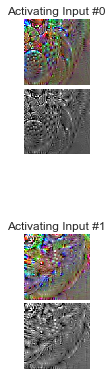

In [139]:
al = analyze_layer(model, 'detectors_spatial', max_learning_elements=2, calculate_repr_inputs=True, trainingset=None, l2_regularizer=0.001)
#display_analyzed_layer(anl_layers[-2], display_limit=None)
display_analyzed_layer(al, max_learning_elements=2, num_cols=1, display_limit=None)

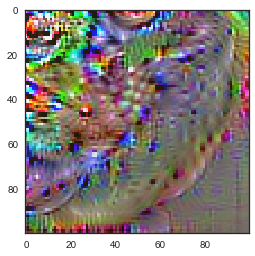

In [151]:
sns.set_style('white')
img = al['learning_elements_repr_inputs'][1]
img = img*X_train_std + X_train_means
img = (img - img.min()) / (img.max() - img.min())
#img = img.clip(0,1)
#img = img*X_train_std + X_train_means
plt.imshow(img, interpolation='nearest')

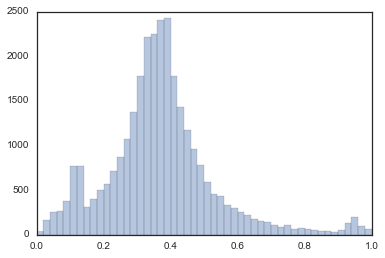

In [146]:
sns.distplot(img.flatten(), kde=False)

In [157]:
sample_idx = np.random.choose(range(data.dev.X.shape[0]), 20)
sample_X = data.dev.X[sample_idx]
sample_y = data.dev.y[sample_idx]

gridplot(sample_X, titles=sample_y)


TypeError: object of type 'int' has no len()

In [134]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_6 (InputLayer)             (None, 100, 100, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 100, 100, 64)  1792        input_6[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 100, 100, 64)  36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 50, 50, 64)    0           block1_conv2[0][0]               
___________________________________________________________________________________________

In [27]:
results_dropout = compare_models(data.train.X, data.train.y, build_model, {
        '(16,16)_32_Dropout_0.1': { 'num_filters': (16,16), 'fc_size': (32,), 'reg': True, 'reg_lambda': 0.1 },
        '(16,16)_32_Dropout_0.01': { 'num_filters': (16,16), 'fc_size': (32,), 'reg': True, 'reg_lambda': 0.01 },
        '(16,16)_32_Dropout_0.001': { 'num_filters': (16,16), 'fc_size': (32,), 'reg': True, 'reg_lambda': 0.001 },
        '(16,16)_32_Dropout_0.0001': { 'num_filters': (16,16), 'fc_size': (32,), 'reg': True, 'reg_lambda': 0.0001 },
    }, nb_epoch=100)

Train on 1058 samples, validate on 265 samples
Epoch 1/100
6s - loss: 0.7374 - acc: 0.5274 - val_loss: 0.6583 - val_acc: 0.5811
Epoch 2/100
4s - loss: 0.6170 - acc: 0.7240 - val_loss: 0.3931 - val_acc: 0.8491
Epoch 3/100
4s - loss: 0.4180 - acc: 0.8422 - val_loss: 0.3541 - val_acc: 0.8717
Epoch 4/100
4s - loss: 0.3502 - acc: 0.8752 - val_loss: 0.7378 - val_acc: 0.6302
Epoch 5/100
4s - loss: 0.4334 - acc: 0.8355 - val_loss: 0.3432 - val_acc: 0.8943
Epoch 6/100
4s - loss: 0.3113 - acc: 0.8828 - val_loss: 0.7194 - val_acc: 0.6340
Epoch 7/100
4s - loss: 0.3269 - acc: 0.8790 - val_loss: 0.3201 - val_acc: 0.8717
Epoch 8/100
4s - loss: 0.2579 - acc: 0.9112 - val_loss: 0.3324 - val_acc: 0.8604
Epoch 9/100
4s - loss: 0.2406 - acc: 0.9216 - val_loss: 0.3027 - val_acc: 0.8679
Epoch 10/100
4s - loss: 0.2449 - acc: 0.9045 - val_loss: 0.2847 - val_acc: 0.8755
Epoch 11/100
4s - loss: 0.2829 - acc: 0.9055 - val_loss: 0.3524 - val_acc: 0.8679
Epoch 12/100
4s - loss: 0.2156 - acc: 0.9291 - val_loss: 0.2

convolving with window_size  5
convolving with window_size  5
convolving with window_size  5
convolving with window_size  5
convolving with window_size  5
convolving with window_size  5
convolving with window_size  5
convolving with window_size  5


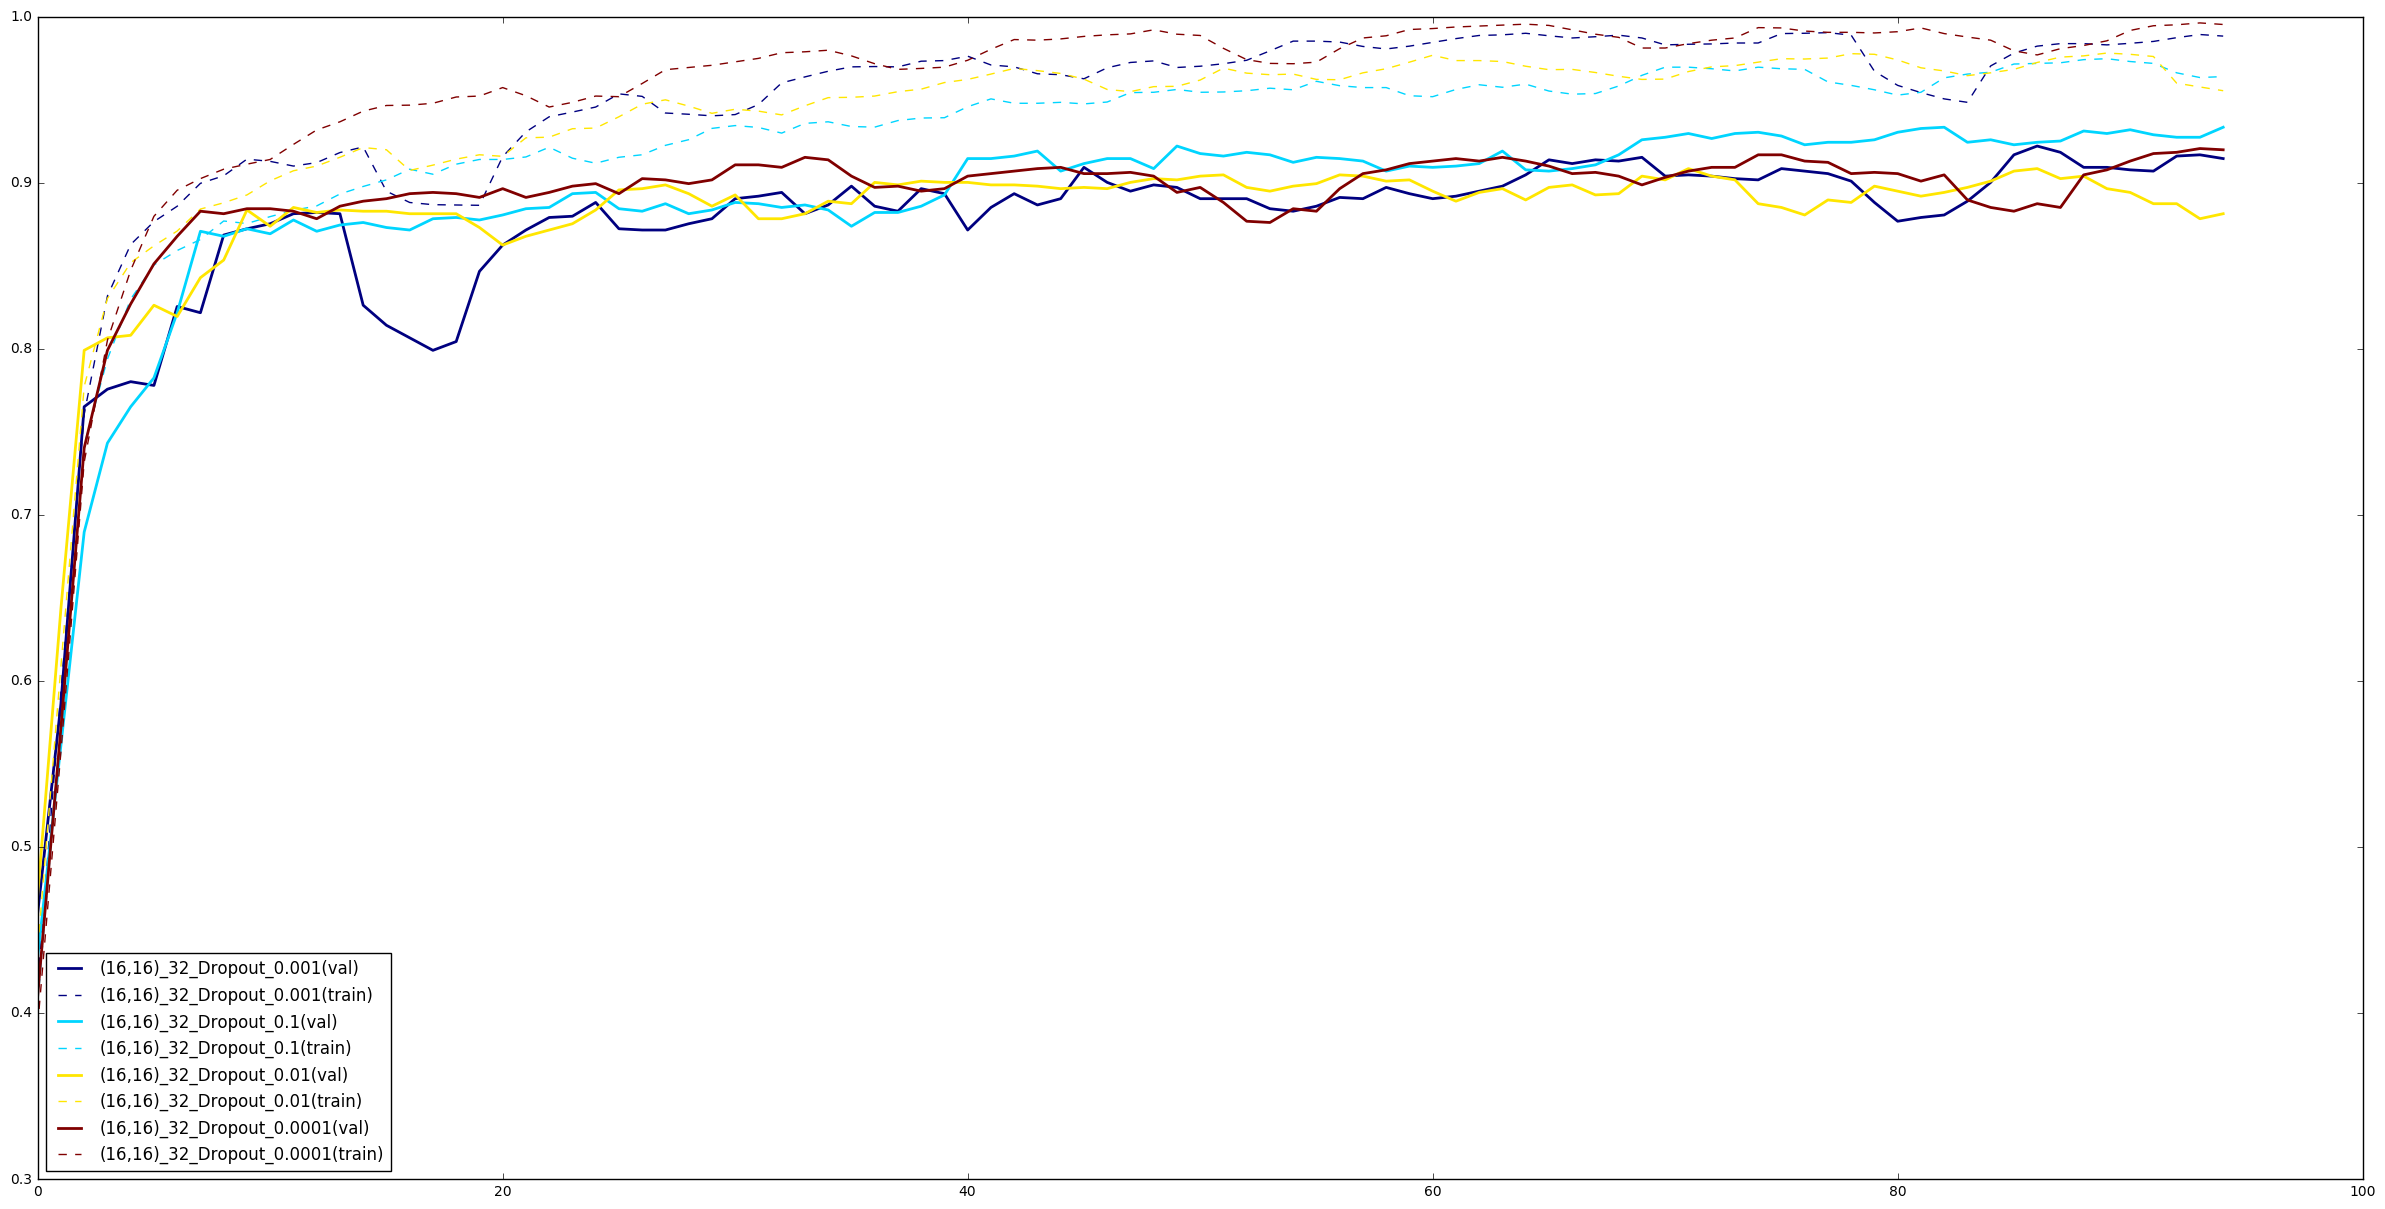

In [45]:
show_results(results_dropout, window_size=5)

In [56]:
print(sklearn.metrics.classification_report(np.argmax(data.train_dev.y, axis=1), np.argmax(model.predict(data.train_dev.X), axis=1)))

             precision    recall  f1-score   support

          0       0.97      0.93      0.95        84
          1       0.91      0.97      0.94        64

avg / total       0.95      0.95      0.95       148



In [74]:
model = keras.models.load_model('model.h5')

In [85]:
pp = model.predict_proba(data.test.X)

490/490 [==============================] - 20s    


In [86]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(data.test.y[:,0], pp[:,0])
auc = sklearn.metrics.auc(fpr, tpr)

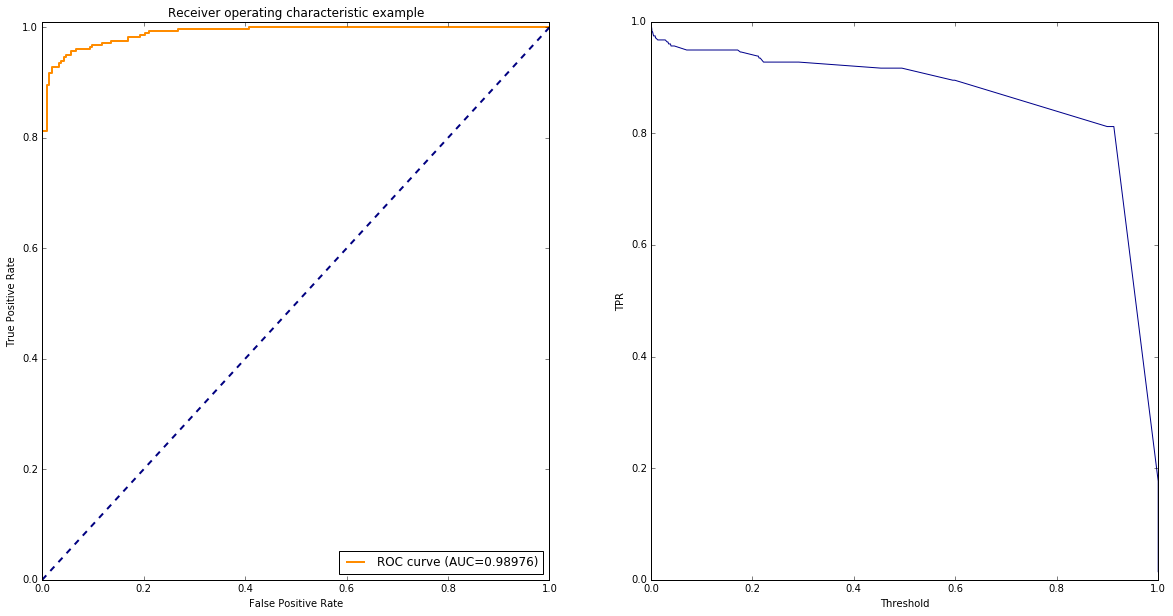

In [87]:
fig, axs = plt.subplots(1,2, figsize=(20,10))

plt.figure()
lw = 2
axs[0].plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (AUC={:.5f})'.format(auc))
axs[0].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
axs[0].set_xlim([0.0, 1.0])
axs[0].set_ylim([0.0, 1.01])
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('Receiver operating characteristic example')
axs[0].legend(loc="lower right")

axs[1].plot(thresholds, tpr, color='darkblue', label='TPR for threshold')
axs[1].set_xlabel('Threshold')
axs[1].set_ylabel('TPR')


plt.show()

In [145]:
rs = data.test.X[np.argmax(data.test.y, axis=1) != np.argmax(pp, axis=1)][:50]
rs_pred = pp[np.argmax(data.test.y, axis=1) != np.argmax(pp, axis=1)][:50]
rs.shape

(27, 3, 100, 100)

In [108]:
print("rs measn  - ", np.mean(rs, axis=(0,2,3)))
print("rgb_means - ", rgb_means)

rs measn  -  [ 0.55837057  0.51539211  0.49636774]
rgb_means -  [ 0.5387489   0.49949211  0.46680889]


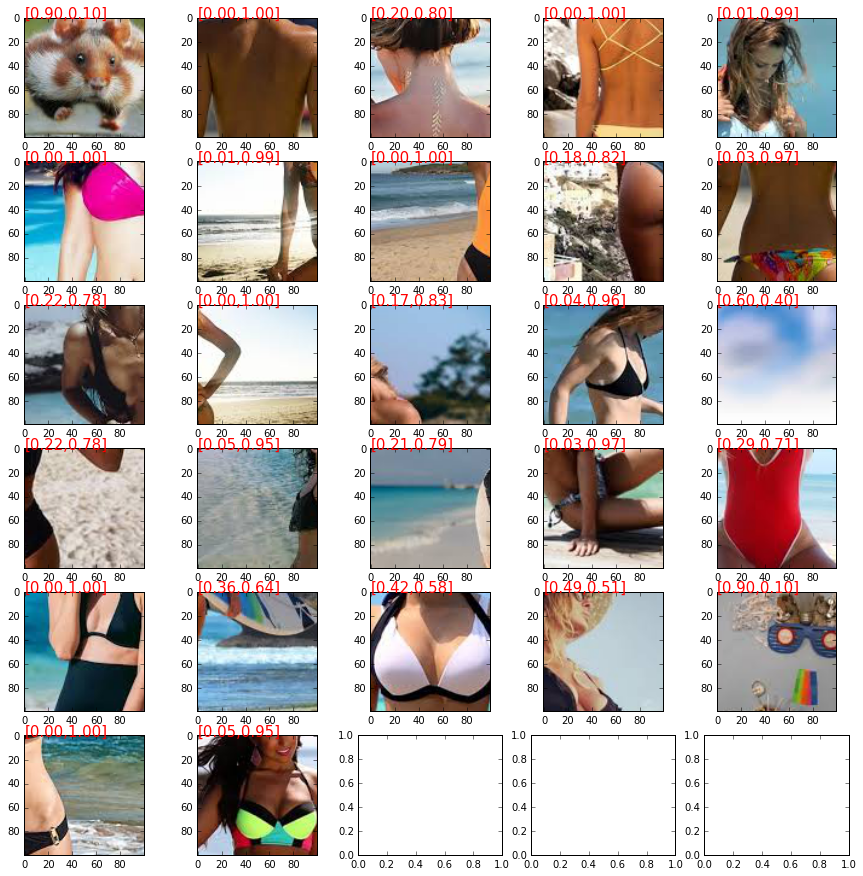

In [146]:
fig, axs = plt.subplots(rs.shape[0]//5 + 1, 5, figsize=(15,15))
axs = axs.flatten()

for idx, z in enumerate(zip(rs, rs_pred)):
    r,r_pred = z
    axs[idx].imshow(r.transpose(1,2,0))
    axs[idx].text(0, 0, "[{:.2f},{:.2f}]".format(*r_pred), color='red', size=15 )

In [178]:
model.layers

ValueError: axes don't match array

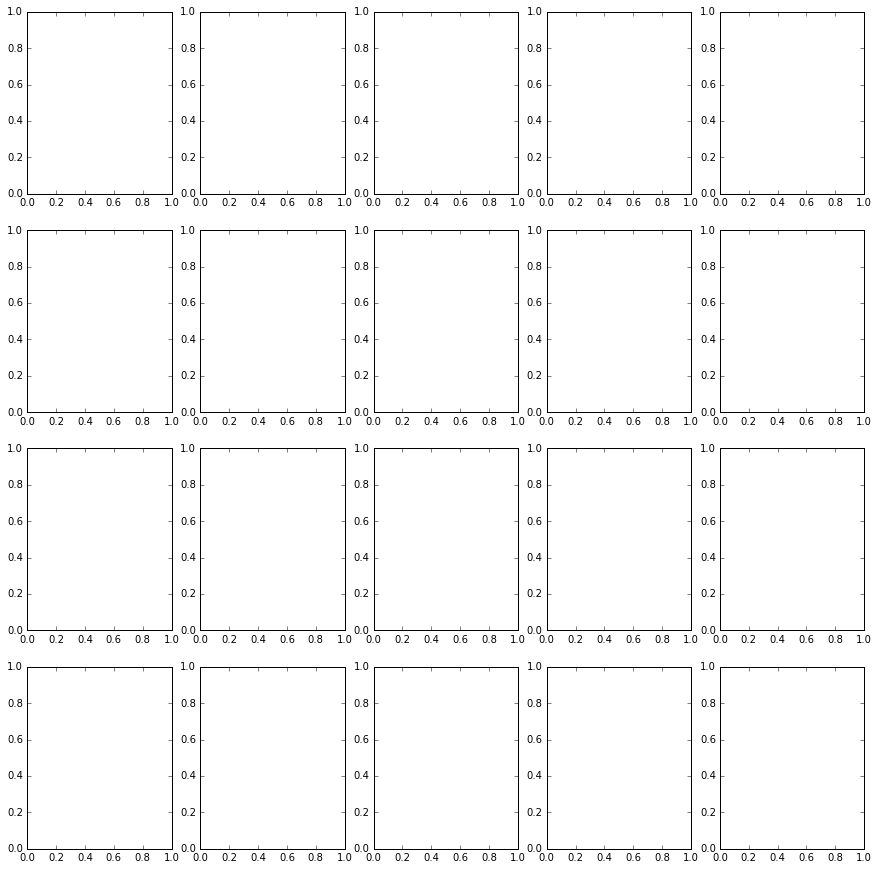

In [184]:
filters = model.layers[1].get_weights()[0]

fig, axs = plt.subplots(filters.shape[0]//5 + 1, 5, figsize=(15,15))
axs = axs.flatten()

for idx, f in enumerate(filters):
    axs[idx].imshow(f.transpose(0), interpolation='nearest')


In [38]:
import pickle

pickle.dump({ 'results_1_layer': results, 'results_2_layers': results_2_layers}, open("results.pickle", "wb"))

In [36]:
for n,h in results_2_layers:
    del h.model